In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [181]:
def create_comparation_table_clustering(pred, X, labels, dict_class_types, class_label):
    ''' Create a dataframe with the values of all the features (denoted by X) and the label results
    of the clustering algorithm, plus class names (table denoted by yhat). Also, returns a comparision table
    with the presence of each class type with each cluster type, if present.
    
    Args:
        - pred (pd.DataFrame): class prediction result
        - X (pd.DataFrame): features dataset, input for prediction
        - labels (pd.Series): true labels of the original dataset
        - dict_class_types (dict): dict with keys being the true class number and values with names.
        - class_label (pd.DataFrame): dataframe with information about data classes (number and name)
        
    Returns:
        - yhat (pd.DataFrame): dataframe with all the feature values plus the results of the model
        - comp_table (pd.DataFrame): dataframe with the results of the clustering model, plus calculations of the presence.
        
        
    '''    
    
    # Create dataframe with features plus prediction values
    yhat = X.copy()
    yhat['cluster_label'] = pred
    yhat['class_label'] = labels
    yhat['class_name'] = yhat['class_label'].replace(dict_class_types)
    
    # Create comparision table with results
    check_labels_w_names = yhat.groupby(['class_label','cluster_label']).size().reset_index()
    check_labels_w_names['class_name'] = check_labels_w_names['class_label'].replace(dict_class_types)
    check_labels_w_names = check_labels_w_names.set_index(['class_name', 'class_label'])
    check_labels_w_names = pd.merge(check_labels_w_names.reset_index(), class_label[['Class_Number', 'Number_Of_Animal_Species_In_Class']], 
            'left', left_on = 'class_label', right_on = 'Class_Number')
    check_labels_w_names = check_labels_w_names.rename({'Number_Of_Animal_Species_In_Class': 'class_total_number',
                                                        0: 'cluster_total_number'}, axis = 1)
    check_labels_w_names['presence_relative_to_class'] = np.round(check_labels_w_names['cluster_total_number']/check_labels_w_names['class_total_number'],3)
    comp_table = check_labels_w_names.set_index(['class_name', 'class_label'])

    return yhat, comp_table

# Data

In [146]:
zoo = pd.read_csv('data/zoo.csv')
class_label = pd.read_csv('data/class.csv')

- First, we see that fot not every animal class we have the same number of rows. In this dataset, the less frequent type of animal are the amphibians, and the most common the mammals. This makes sense for a zoo, which contains a variety of different animals.

In [147]:
class_label

,Class_Number,Number_Of_Animal_Species_In_Class,Class_Type,Animal_Names
0,1,41,Mammal,"aardvark, antelope, bear, boar, buffalo, calf,..."
1,2,20,Bird,"chicken, crow, dove, duck, flamingo, gull, haw..."
2,3,5,Reptile,"pitviper, seasnake, slowworm, tortoise, tuatara"
3,4,13,Fish,"bass, carp, catfish, chub, dogfish, haddock, h..."
4,5,4,Amphibian,"frog, frog, newt, toad"
5,6,8,Bug,"flea, gnat, honeybee, housefly, ladybird, moth..."
6,7,10,Invertebrate,"clam, crab, crayfish, lobster, octopus, scorpi..."


- As it is stated on the source page of the dataset, the zoo dataframe contains information about characteristics of each animal. Mostly of the features are of boolean type, except for _legs_ which is a numerical column. This is the dataset we will use to analyze information and to develop our model.

In [148]:
zoo

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,wallaby,1,0,0,1,0,0,0,1,1,1,0,0,2,1,0,1,1
97,wasp,1,0,1,0,1,0,0,0,0,1,1,0,6,0,0,0,6
98,wolf,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
99,worm,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,7


# Analysis

## EDA

- First, let's see the presence of each of the variables in the dataset.
- Since the majority of these features are boolean (legs is numerical, and class_type is the label to verify our results), computing the mean is equivalent to the percentage of rows that are true for that feature.

In [149]:
zoo.describe().loc['mean']

hair          0.425743
feathers      0.198020
eggs          0.584158
milk          0.405941
airborne      0.237624
aquatic       0.356436
predator      0.554455
toothed       0.603960
backbone      0.821782
breathes      0.792079
venomous      0.079208
fins          0.168317
legs          2.841584
tail          0.742574
domestic      0.128713
catsize       0.435644
class_type    2.831683
Name: mean, dtype: float64

In [150]:
zoo

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,wallaby,1,0,0,1,0,0,0,1,1,1,0,0,2,1,0,1,1
97,wasp,1,0,1,0,1,0,0,0,0,1,1,0,6,0,0,0,6
98,wolf,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
99,worm,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,7


In [151]:
non_boolean_features = ['legs', 'class_type']
numerical_features = ['legs']
animal_names_column = ['animal_name']


col_set = set(list(zoo.columns))
boolean_features = col_set-set(non_boolean_features+animal_names_column)
boolean_features_w_class = col_set - set(numerical_features+animal_names_column)

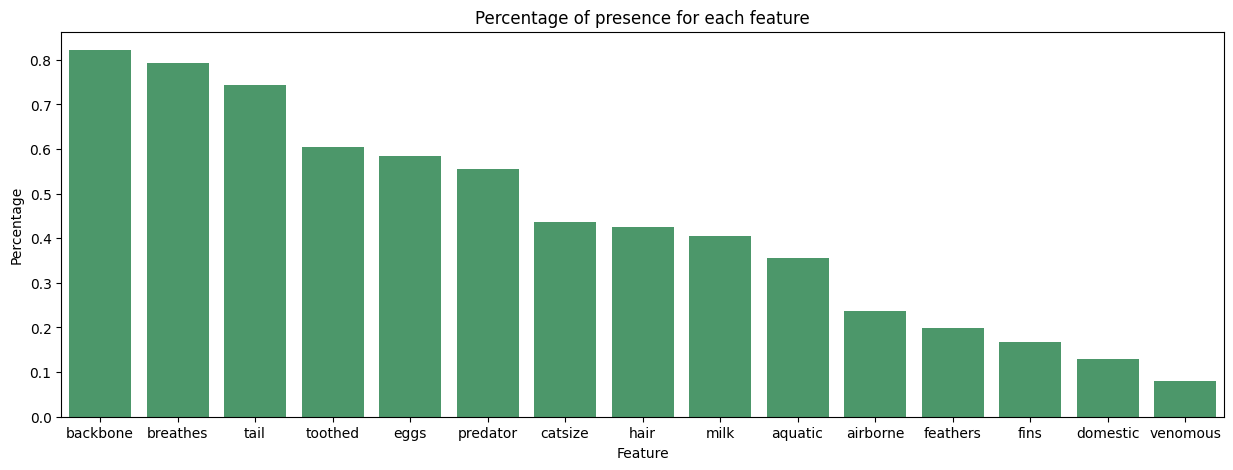

In [152]:
plt.figure( figsize = (15,5))

ax = sns.barplot(data = zoo.describe().loc['mean'].drop(non_boolean_features).sort_values(ascending = False),
                 color = sns.xkcd_rgb['greenish'])

ax.set_title('Percentage of presence for each feature')
ax.set_xlabel('Feature')
ax.set_ylabel('Percentage')

plt.show()

In [153]:
zoo[zoo['backbone'] != 1]

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
13,clam,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,7
14,crab,0,0,1,0,0,1,1,0,0,0,0,0,4,0,0,0,7
15,crayfish,0,0,1,0,0,1,1,0,0,0,0,0,6,0,0,0,7
24,flea,0,0,1,0,0,0,0,0,0,1,0,0,6,0,0,0,6
30,gnat,0,0,1,0,1,0,0,0,0,1,0,0,6,0,0,0,6
39,honeybee,1,0,1,0,1,0,0,0,0,1,1,0,6,0,1,0,6
40,housefly,1,0,1,0,1,0,0,0,0,1,0,0,6,0,0,0,6
42,ladybird,0,0,1,0,1,0,1,0,0,1,0,0,6,0,0,0,6
46,lobster,0,0,1,0,0,1,1,0,0,0,0,0,6,0,0,0,7
51,moth,1,0,1,0,1,0,0,0,0,1,0,0,6,0,0,0,6


In [154]:
zoo[zoo['backbone'] != 1].groupby('class_type').size()

class_type
6     8
7    10
dtype: int64

In [155]:
zoo[zoo['breathes'] != 1]

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
7,carp,0,0,1,0,0,1,0,1,1,0,0,1,0,1,1,0,4
8,catfish,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
12,chub,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
13,clam,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,7
14,crab,0,0,1,0,0,1,1,0,0,0,0,0,4,0,0,0,7
15,crayfish,0,0,1,0,0,1,1,0,0,0,0,0,6,0,0,0,7
18,dogfish,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,1,4
34,haddock,0,0,1,0,0,1,0,1,1,0,0,1,0,1,0,0,4
38,herring,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4


In [156]:
zoo[zoo['breathes'] != 1].groupby('class_type').size()

class_type
3     1
4    13
7     7
dtype: int64

In [157]:
class_label.rename({'Class_Type': 'class_type'}, axis = 1).set_index('class_type')['Number_Of_Animal_Species_In_Class']

class_type
Mammal          41
Bird            20
Reptile          5
Fish            13
Amphibian        4
Bug              8
Invertebrate    10
Name: Number_Of_Animal_Species_In_Class, dtype: int64

- Refering to the last behaviour we noticed, there seems to be "unique" features for certain types of classes. For example, mammals (class 1) are the ones that only drink milk. Another example could be the presence of fins, which are mostly present in the fish class (number 4). The same thing with feathers and the bird class.  

- In general we see that many features have explainibility on the majority of classes.

In [158]:
pd.concat([zoo[list(boolean_features_w_class)].groupby('class_type').mean(),
           class_label.rename({'Class_Number': 'class_type'}, axis = 1).set_index('class_type')['Number_Of_Animal_Species_In_Class'].rename('size')], 
          axis = 1)

,feathers,milk,aquatic,predator,catsize,venomous,hair,backbone,toothed,fins,breathes,tail,airborne,eggs,domestic,size
class_type,,,,,,,,,,,,,,,,
1,0.0,1.0,0.146341,0.536585,0.780488,0.000000,0.95122,1.0,0.97561,0.097561,1.0,0.853659,0.04878,0.02439,0.195122,41
2,1.0,0.0,0.300000,0.450000,0.300000,0.000000,0.00000,1.0,0.00000,0.000000,1.0,1.000000,0.80000,1.00000,0.150000,20
3,0.0,0.0,0.200000,0.800000,0.200000,0.400000,0.00000,1.0,0.80000,0.000000,0.8,1.000000,0.00000,0.80000,0.000000,5
4,0.0,0.0,1.000000,0.692308,0.307692,0.076923,0.00000,1.0,1.00000,1.000000,0.0,1.000000,0.00000,1.00000,0.076923,13
5,0.0,0.0,1.000000,0.750000,0.000000,0.250000,0.00000,1.0,1.00000,0.000000,1.0,0.250000,0.00000,1.00000,0.000000,4
6,0.0,0.0,0.000000,0.125000,0.000000,0.250000,0.50000,0.0,0.00000,0.000000,1.0,0.000000,0.75000,1.00000,0.125000,8
7,0.0,0.0,0.600000,0.800000,0.100000,0.200000,0.00000,0.0,0.00000,0.000000,0.3,0.100000,0.00000,0.90000,0.000000,10


In [159]:
class_label

,Class_Number,Number_Of_Animal_Species_In_Class,Class_Type,Animal_Names
0,1,41,Mammal,"aardvark, antelope, bear, boar, buffalo, calf,..."
1,2,20,Bird,"chicken, crow, dove, duck, flamingo, gull, haw..."
2,3,5,Reptile,"pitviper, seasnake, slowworm, tortoise, tuatara"
3,4,13,Fish,"bass, carp, catfish, chub, dogfish, haddock, h..."
4,5,4,Amphibian,"frog, frog, newt, toad"
5,6,8,Bug,"flea, gnat, honeybee, housefly, ladybird, moth..."
6,7,10,Invertebrate,"clam, crab, crayfish, lobster, octopus, scorpi..."


- The next heatmap could visualize better this situation.

In [160]:
gb = pd.concat([zoo[list(boolean_features_w_class)].groupby('class_type').mean(),
           class_label.rename({'Class_Number': 'class_type'}, axis = 1).set_index('class_type')['Number_Of_Animal_Species_In_Class'].rename('size')], 
          axis = 1)

dict_class_types = dict(zip(class_label['Class_Number'], class_label['Class_Type']))
gb.index = [dict_class_types[x] for x in gb.index]

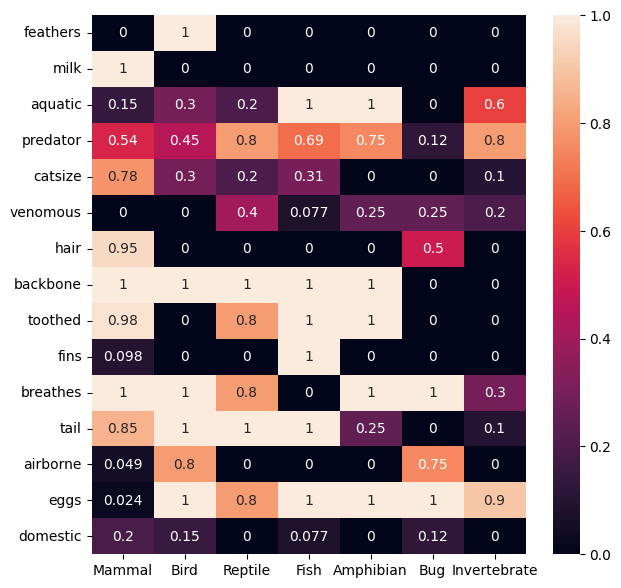

In [161]:
plt.figure(figsize = (7,7))

sns.heatmap(gb.drop('size', axis = 1).T, annot = True)

plt.show()

- Hey, but, what about the numbers of legs?

In [162]:
zoo['class_names'] = zoo['class_type'].replace(dict_class_types)

- We can say that mainly there's more animals between 0 and 4 legs, with some classes being more frequent in certain n° of legs.
- For example mammals (in this zoo), often have 4 legs, although is possible too to find them with 2 or even zero (less probable).
- All bugs have 6 legs, birds have 2 legs, and fishes have 0 legs. Also, reptiles are common with 0 and 4 legs. 
- Invertebrate animals are distributed between all nummber of legs.

- This, in combination with the other features, is very significant to identify the type of animal is present. Although, could our algorithm discover it by itself?

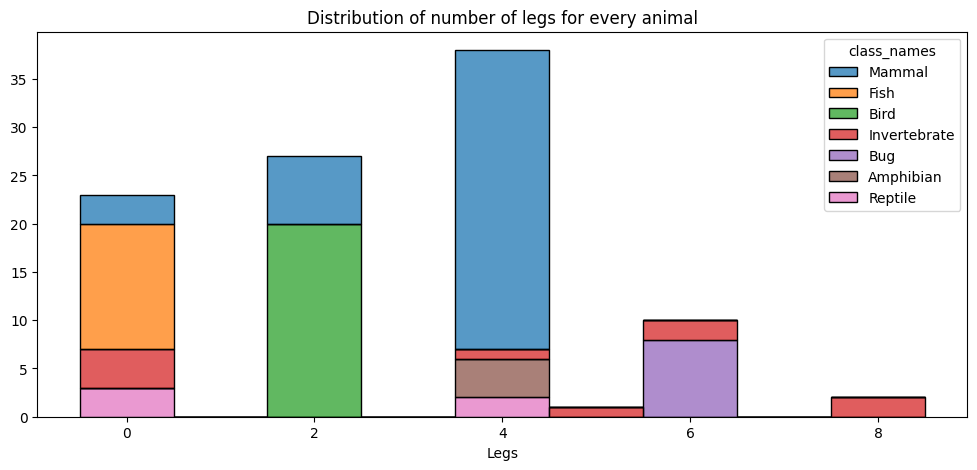

In [163]:
plt.figure(figsize = (12,5))

ax = sns.histplot(data = zoo, x ='legs' , 
                  hue ='class_names',
                  multiple = 'stack',
                  discrete = True)
ax.set_title('Distribution of number of legs for every animal')
ax.set_xlabel('Legs')
ax.set_ylabel('')

plt.show()

# Modeling
- Let's see what we can do with baseline clustering models.
- Then, if needed, we will do PCA and other transformations of data if the result isn't the best.

In [164]:
from sklearn.cluster import KMeans

- Prepare the data for input in algorithms

In [165]:
labels = zoo['class_type']
X = zoo.drop(['animal_name', 'class_type', 'class_names'], axis = 1).copy()


In [166]:
k = 7
kmeans = KMeans(n_clusters = k)
y_pred = kmeans.fit_predict(X)

In [167]:
y_pred

array([0, 0, 3, 0, 0, 0, 0, 3, 3, 0, 0, 2, 3, 4, 5, 1, 2, 0, 3, 3, 2, 2,
       0, 2, 1, 5, 5, 6, 0, 6, 1, 0, 6, 2, 3, 0, 0, 2, 3, 1, 1, 2, 1, 2,
       0, 0, 1, 0, 0, 0, 0, 1, 5, 1, 0, 0, 2, 2, 2, 2, 3, 3, 4, 0, 0, 0,
       3, 0, 0, 0, 0, 2, 1, 3, 3, 6, 3, 4, 2, 2, 4, 4, 3, 2, 6, 1, 3, 2,
       1, 5, 5, 5, 3, 6, 0, 2, 6, 1, 0, 4, 2], dtype=int32)

In [168]:
kmeans.cluster_centers_[2]

array([-1.66533454e-16,  1.00000000e+00,  1.00000000e+00, -1.66533454e-16,
        8.00000000e-01,  3.00000000e-01,  4.50000000e-01,  1.11022302e-16,
        1.00000000e+00,  1.00000000e+00, -1.38777878e-17, -2.77555756e-17,
        2.00000000e+00,  1.00000000e+00,  1.50000000e-01,  3.00000000e-01])

In [171]:
yhat, comp_table = create_comparation_table_clustering(y_pred, X, labels, dict_class_types, class_label)

- For the first run, we have pretty good results. Our model could clusterize correctly the Bird, Fish, Amphibian and Bug classes.
- We can see that for mammals, there's also a good presence on cluster label 2 (being 31 of this label), but we still have some missclasified clusters.
- Reptiles and Invertebrate, don't have the best result, but we can try doing some other things to increase even more the quality of our model. Not in a particular order:
    - Delete features, reduce dimensionality.
    - Try other models.
    - Transform the data (create a joint class, for example)
    - PCA
    - Feature Engineering
    

In [172]:
comp_table

cluster_label  cluster_total_number  Class_Number  \
class_name   class_label                                                      
Mammal       1                        0                    31             1   
             1                        3                     3             1   
             1                        6                     7             1   
Bird         2                        2                    20             2   
Reptile      3                        3                     1             3   
             3                        4                     2             3   
             3                        5                     2             3   
Fish         4                        3                    13             4   
Amphibian    5                        5                     4             5   
Bug          6                        1                     8             6   
Invertebrate 7                        1                     5             7   
             7                        4                     4             7   
             7                        5                     1             7   

                          class_total_number  presence_relative_to_class  
class_name   class_label                                                  
Mammal       1                            41                       0.756  
             1                            41                       0.073  
             1                            41                       0.171  
Bird         2                            20                       1.000  
Reptile      3                             5                       0.200  
             3                             5                       0.400  
             3                             5                       0.400  
Fish         4                            13                       1.000  
Amphibian    5                             4                       1.000  
Bug          6                             8                       1.000  
Invertebrate 7                            10                       0.500  
             7                            10                       0.400  
             7                            10                       0.100

In [173]:
gb_clusters = pd.DataFrame(kmeans.cluster_centers_, columns = X.columns).astype('float16').reset_index().rename({'index': 'label_cluster'}, axis = 1)
gb_clusters = gb_clusters.drop(['legs', 'label_cluster'], axis = 1)

- We see that for some classes, we calculated a very close approximation, comparing it with the mean values for each group and their respective feature.
- For example, for Mammals we see a strong correlation of features with the group 2 cluster label. Also Bird with cluster 1, Fish with group 3, Amphibian with group 6, Bug with group 0.
- Group 4 and 5 contains a weird mix of every feature. You can see it in the table we computed; label 4 is also present in the mammal label, while label 5 is around invertebrate and reptile classes.
- Maybe we can delete some features to make the model simpler and have better results?

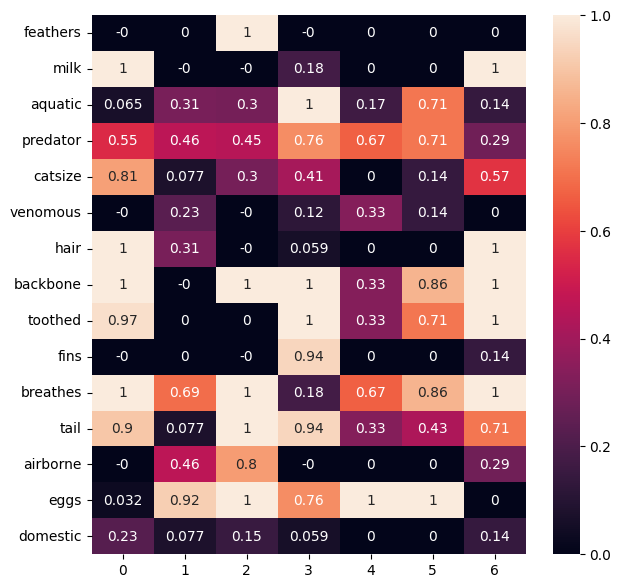

In [174]:
plt.figure(figsize = (7,7))

sns.heatmap(data = gb_clusters[gb.drop(['size'], axis = 1).columns].T, annot = True)

plt.show()

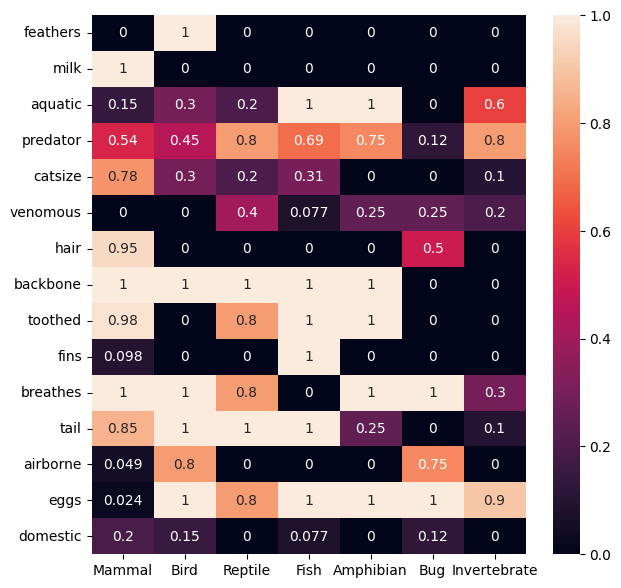

In [34]:
plt.figure(figsize = (7,7))

sns.heatmap(gb.drop('size', axis = 1).T, annot = True)

plt.show()

- We'll first try with these classes: predator, catsize, venomous, domestic
- Why these features? Mainly because they do not offer much information to the model. We can see that for each class the presence of each of these features do not represent critically many classes. (todo: explain this better)

In [175]:
k = 7
kmeans = KMeans(n_clusters = k)
y_pred = kmeans.fit_predict(X.drop(['predator', 'catsize', 'venomous', 'domestic'], axis = 1))

In [177]:
yhat, comp_table = create_comparation_table_clustering(y_pred, X, labels, dict_class_types, class_label)

- Our model keeps on labelling classes that dont correspond, especially on mammals, invertrebates and reptiles.

In [178]:
comp_table

cluster_label  cluster_total_number  Class_Number  \
class_name   class_label                                                      
Mammal       1                        0                    31             1   
             1                        1                     3             1   
             1                        5                     7             1   
Bird         2                        2                    20             2   
Reptile      3                        1                     3             3   
             3                        3                     2             3   
Fish         4                        1                    13             4   
Amphibian    5                        3                     4             5   
Bug          6                        6                     8             6   
Invertebrate 7                        1                     4             7   
             7                        3                     2             7   
             7                        4                     4             7   

                          class_total_number  presence_relative_to_class  
class_name   class_label                                                  
Mammal       1                            41                       0.756  
             1                            41                       0.073  
             1                            41                       0.171  
Bird         2                            20                       1.000  
Reptile      3                             5                       0.600  
             3                             5                       0.400  
Fish         4                            13                       1.000  
Amphibian    5                             4                       1.000  
Bug          6                             8                       1.000  
Invertebrate 7                            10                       0.400  
             7                            10                       0.200  
             7                            10                       0.400

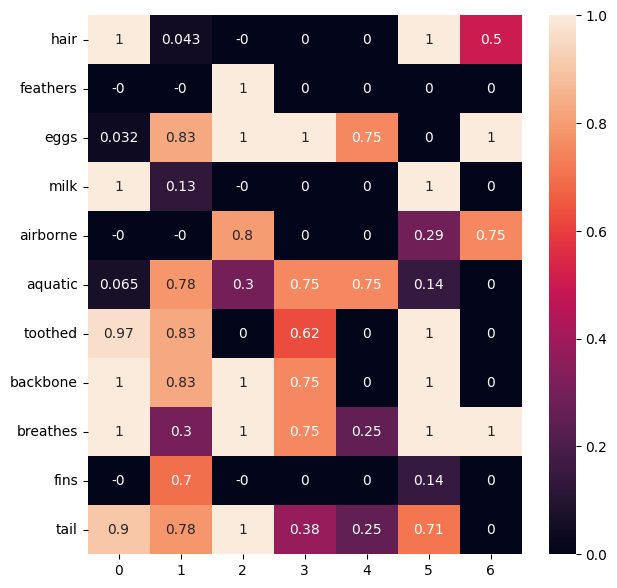

In [179]:
plt.figure(figsize = (7,7))

sns.heatmap(pd.DataFrame(np.round(kmeans.cluster_centers_,3), columns = X.drop(['predator', 'catsize', 'venomous', 'domestic'], axis = 1).columns).drop('legs', axis = 1).T, annot = True)

plt.show()

## DBSCAN

In [82]:
from sklearn.cluster import DBSCAN

In [126]:
dbsc = DBSCAN(eps = 1,min_samples = 3).fit_predict(X)
print(dbsc)

print(f'Unique values: {len(set(dbsc))}')

[ 0  0  1  0  0  0  0  1  1  0  0  2  1 -1  3  3  2  0  1 -1  2  2  0  2
  4  5  5  6  0 -1  4  0  6  2  1  0  0  2  1  4  4  2  4  2  0  0  3  0
  0  0  0  4  5 -1  0  0  2  2  2  2  1  1 -1 -1  0  0 -1  0  0  0  0  2
 -1  1 -1 -1 -1 -1  2  2 -1 -1  1  2  6  3  1  2  4  5 -1  5  1  6  0  2
  6  4  0 -1  2]
Unique values: 8


In [142]:
yhat, comp_table = create_comparation_table_clustering(dbsc, X, labels, dict_class_types, class_label)

In [140]:
dict_class_types

{1: 'Mammal',
 2: 'Bird',
 3: 'Reptile',
 4: 'Fish',
 5: 'Amphibian',
 6: 'Bug',
 7: 'Invertebrate'}

In [136]:
comp_table

cluster_label  cluster_total_number  Class_Number  \
class_name   class_label                                                      
Mammal       1                       -1                     6             1   
             1                        0                    30             1   
             1                        6                     5             1   
Bird         2                        2                    20             2   
Reptile      3                       -1                     4             3   
             3                        5                     1             3   
Fish         4                        1                    13             4   
Amphibian    5                        5                     4             5   
Bug          6                        4                     8             6   
Invertebrate 7                       -1                     6             7   
             7                        3                     4             7   

                          class_total_number  presence_relative_to_class  
class_name   class_label                                                  
Mammal       1                            41                       0.146  
             1                            41                       0.732  
             1                            41                       0.122  
Bird         2                            20                       1.000  
Reptile      3                             5                       0.800  
             3                             5                       0.200  
Fish         4                            13                       1.000  
Amphibian    5                             4                       1.000  
Bug          6                             8                       1.000  
Invertebrate 7                            10                       0.600  
             7                            10                       0.400

In [128]:
ydf_dbs

,hair,feathers,eggs,milk,airborne,aquatic,toothed,backbone,breathes,fins,legs,tail,cluster_label,class_label,class_name
0,1,0,0,1,0,0,1,1,1,0,4,0,0,1,Mammal
1,1,0,0,1,0,0,1,1,1,0,4,1,0,1,Mammal
2,0,0,1,0,0,1,1,1,0,1,0,1,1,4,Fish
3,1,0,0,1,0,0,1,1,1,0,4,0,0,1,Mammal
4,1,0,0,1,0,0,1,1,1,0,4,1,0,1,Mammal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1,0,0,1,0,0,1,1,1,0,2,1,6,1,Mammal
97,1,0,1,0,1,0,0,0,1,0,6,0,4,6,Bug
98,1,0,0,1,0,0,1,1,1,0,4,1,0,1,Mammal
99,0,0,1,0,0,0,0,0,1,0,0,0,-1,7,Invertebrate
